In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

import os
os.environ.setdefault('DJANGO_SETTINGS_MODULE', 'politik.settings')
import django
django.setup()

%matplotlib inline

# Lidt info at huske på

## 4 stemmetyper:
    * 1: For
    * 2: Imod
    * 3: Fraværende
    * 4: Hverken for eller imod
    
## 4 afstemningstyper
    * 1: Endelig
    * 2: Udvalgsindstilling
    * 3: Forslag til vedtagelse
    * 4: Ændringsforslag
    
## 5 Mødetyper
    * 1: Møde i salen
    * 2: Udvalgsmøde
    * 3: Andet møde
    * 4: ConciergeMeeting
    * 5: Statsrevisormøde
    
## 12 Aktørtyper
    * 5: Person

# Hvad kan vi så spørge om...
* Hvem stemmer mest nej? (person, parti)
* Hvem stemmer mest ja?  (person, parti)
* Hvis vi køre PCA (eller MCA eller CorEx) på personer, kommer de så til at cluster efter parti? Er der nogen der hører til et andet sted?
* Hvis vi gør det samme på parti niveau ser vi så vestre vs højre fløj?
* Hvem er den mest/mindst parti loyale person?
* ...


In [36]:
from poligraf.models import Aktør, Stemme
from django.db.models import Count, Avg, 

In [90]:
stemt = [list(a.stemme_set.all().values('typeid').annotate(Count('typeid'))) + [{'navn':a.navn}] for a in Aktør.objects.filter(typeid=5)]

In [121]:
stemme_type = {1:'for', 2:'imod', 3:'fraværende', 4:'neutral'}

In [122]:
stemt_better = []
for i, x in enumerate(stemt):
    linje = {'navn':x[-1]['navn']}
    for z in x:
        if 'typeid' in z.keys():
            if z['typeid'] in [1,2,3,4]:
                linje[stemme_type[z['typeid']]] = z['typeid__count']
    stemt_better.append(linje)
    

In [125]:
stemt_data = pd.DataFrame(stemt_better).set_index('navn')
stemt_data.head()

,for,fraværende,imod,neutral
navn,,,,
Frank Aaen,337.0,218.0,198.0,12.0
Nicolai Wammen,160.0,787.0,130.0,3.0
Sara Olsvig,NaN,358.0,NaN,NaN
Christine Antorini,246.0,690.0,144.0,NaN
Alex Ahrendtsen,375.0,440.0,228.0,33.0


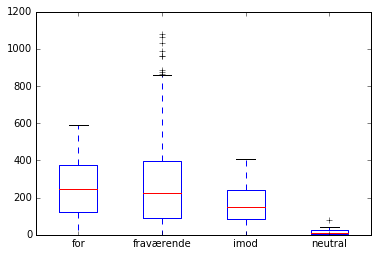

In [127]:
stemt_data.plot(kind='box')